In [0]:
#https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [3]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [4]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
def load_img(path):
    max_dim = 512
    img = Image.open(path)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    #batch dimension broadcasting
    return img
    

In [9]:
ls

1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Green_Sea_Turtle_grazing_seagrass.jpg
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
sample_data/
The_Great_Wave_off_Kanagawa.jpg
Tuebingen_Neckarfront.jpg
Vassily_Kandinsky,_1913_-_Composition_7.jpg


In [0]:
def imshow(img, title = None):
    #remove batch dims
    out = np.squeeze(img, axis = 0)
    #normalize
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)
    

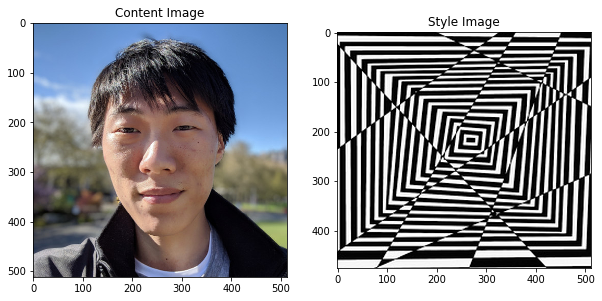

In [83]:
content_path = 'eric.jpeg'
style_path = 'render-670844_960_720.jpg.jpg'

plt.figure(figsize = (10, 10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, "Style Image")
plt.show()

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR.

In [0]:
def load_and_preprocess_img(path):
    img = load_img(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img
    
def load_and_process_img(path):
    img = load_img(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img
    

inverse of preprocessing to view outputs, clipped from 0-255

In [0]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("invalid input to deprocessing stage")
    
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    
    

In [0]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

model = Model(inputs, outputs), load our pretrained image classification network. Then we grab the layers of interest as we defined earlier. Then we define a Model by setting the model’s inputs to an image and the outputs to the outputs of the style and content layers.

In [0]:
def get_model():
    """
    returns: a keras model that takes image input and outputs
    style and content intermediate layers
    """
    vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg.input, model_outputs)
    

In [17]:
"""
Content Loss
loss is the distance from the feature rep of output image 
and the feature representation of the content image
"""

'\nContent Loss\nloss is the distance from the feature rep of output image \nand the feature representation of the content image\n'

In [0]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [19]:
"""
Style Loss
-compare gram matrices of base image output and style 
-image output - distance between style representations
-style representation def: corr of different filter responses
given by the gram matrix
-to generate style for base input image, gradient descent on 
original image to match style representations
"""

'\nStyle Loss\n-compare gram matrices of base image output and style \n-image output - distance between style representations\n-style representation def: corr of different filter responses\ngiven by the gram matrix\n-to generate style for base input image, gradient descent on \noriginal image to match style representations\n'

In [0]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_tgt):
    #expects 2 images w same h, w, c
    #scale loss at given layer by size of feature map and number of filters
    h, w, c = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_tgt))
    
    

In [0]:
def get_feature_representations(model, content_path, style_path):
    #helper to compute content and style feat representations
    #load and preprocess both images and feed through net to get intermediate layer outputs
    
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    style_features = [layer[0] for layer in style_outputs[:num_style_layers]]
    content_features = [layer[0] for layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features
    

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    #compute total loss
    #loss weights: (style weight, content weight, and total variation weight)
    
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight
    
    loss = style_score + content_score
    return loss, style_score, content_score
    
    

In [0]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iter = 1000, content_weight = 1e3, style_weight = 1e-3):
    #freeze layers
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    #get style and content feat representations
    style_feats, content_feats = get_feature_representations(model, content_path, style_path)
    gram_style_feats = [gram_matrix(feature) for feature in style_feats]
    
    #set init image
    init_img = load_and_process_img(content_path)
    init_img = tf.Variable(init_img, dtype = tf.float32)
    opt = tf.train.AdamOptimizer(learning_rate = 5, beta1 = 0.99, epsilon = 1e-1)
    
    iter_count = 1
    
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_img,
        'gram_style_features': gram_style_feats,
        'content_features': content_feats
    }
    
    num_rows = 2
    num_cols = 5
    display_interval = num_iter/(num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs = []
    for i in range(num_iter):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_img)])
        clipped = tf.clip_by_value(init_img, min_vals, max_vals)
        init_img.assign(clipped)
        end_time = time.time()
        
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_img.numpy())
            
        if i % display_interval == 0:
            start_time = time.time()
            
            plt_img = init_img.numpy()
            plt_img = deprocess_img(plt_img)
            imgs.append(plt_img)
            IPython.display.clear_output(wait = True)
            IPython.display.display_png(Image.fromarray(plt_img))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                 'style loss: {:.4e}, '
                 'content loss: {:.4e},'
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait = True)
    plt.figure(figsize = (14, 4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
            
    return best_img, best_loss
        
    
    

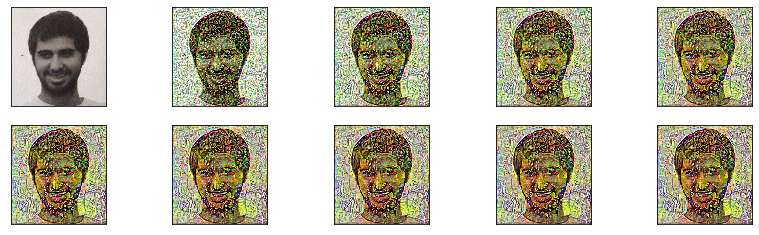

In [110]:
content_path = 'nv2.jpg'
style_path = "the-weeping-woman.jpg"
best, best_loss = run_style_transfer(content_path, style_path)

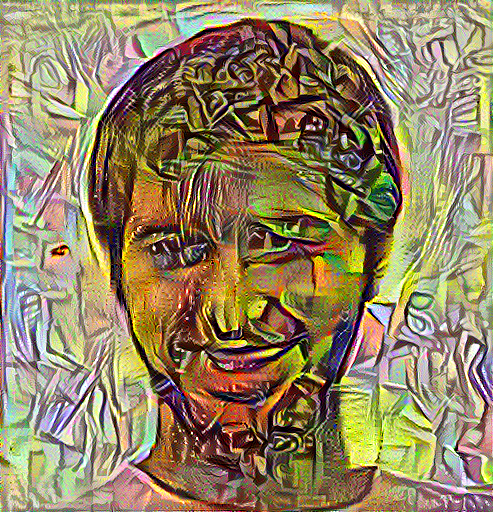

In [111]:

Image.fromarray(best)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

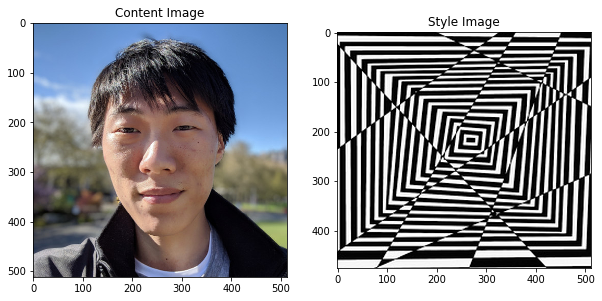

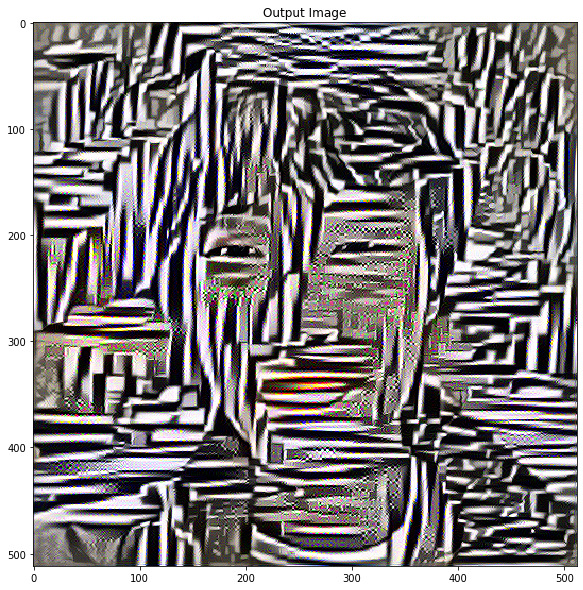

In [86]:
show_results(best, content_path, style_path)